## 모델 튜닝 챌린지 : RF 하이퍼파라미터 최적화 경진대회

**train.csv**  
데이터 전처리 과정이 끝난 학습 데이터 (추가 데이터 전처리 과정을 진행하지 않습니다.)
- RF 모델 하이퍼파라미터를 제출 시, 해당 데이터로 자동적으로 학습됩니다.
- person_id: 유저별 고유 아이디
- Sex: 성별
- past_login_total: 과거(5월 8일 이전)에 로그인한 총 횟수
- past_1_month_login: 과거 1달간 로그인한 총 횟수
- past_1_week_login: 과거 1주간 로그인한 총 횟수
- sub_size: 과거에 데이콘 대회에서의 총 제출 수
- email_type: 가입한 이메일 종류
- phone_rat: 폰으로 접속한 비율
- apple_rat: 애플 기기로 접속한 비율
- login: 로그인 여부

**sample_submission.csv** 
RF 모델을 학습시킬 모델 하이퍼파라미터 목록
- n_estimators:

기본값: 10

범위: 10 ~ 1000 사이의 양의 정수. 일반적으로 값이 클수록 모델 성능이 좋아지지만, 계산 비용과 시간도 증가합니다.

- criterion:

기본값: 'gini'

옵션: 'gini', 'entropy'. 'gini'는 진니 불순도를, 'entropy'는 정보 이득을 기준으로 합니다.
- max_depth:

기본값: None

범위: None 또는 양의 정수. None으로 설정하면 노드가 모든 리프가 순수해질 때까지 확장됩니다. 양의 정수를 설정하면 트리의 최대 깊이를 제한합니다.
- min_samples_split:

기본값: 2

범위: 2 이상의 정수 또는 0과 1 사이의 실수 (비율을 나타냄, (0, 1] ). 내부 노드를 분할하기 위해 필요한 최소 샘플 수를 지정합니다.
- min_samples_leaf:

기본값: 1

범위: 1 이상의 정수 또는 0과 0.5 사이의 실수 (비율을 나타냄, (0, 0.5] ). 리프 노드가 가져야 하는 최소 샘플 수를 지정합니다.
- min_weight_fraction_leaf:

기본값: 0.0

범위: 0.0에서 0.5 사이의 실수. 리프 노드에 있어야 하는 샘플의 최소 가중치 비율을 지정합니다.
- max_features:

기본값: 'auto'

옵션: 'auto', 'sqrt', 'log2', None 또는 양의 정수/실수. 최적의 분할을 찾기 위해 고려할 특성의 수 또는 비율을 지정합니다. 'auto'는 모든 특성을 사용함을 의미하며, 'sqrt'와 'log2'는 각각 특성의 제곱근과 로그2를 사용합니다. None은 'auto'와 동일하게 모든 특성을 의미합니다.
- max_leaf_nodes:

기본값: None

범위: None 또는 양의 정수. 리프 노드의 최대 수를 제한합니다. None은 무제한을 의미합니다.
- min_impurity_decrease:

기본값: 0.0

범위: 0.0 이상의 실수. 노드를 분할할 때 감소해야 하는 불순도의 최소량을 지정합니다.
- bootstrap:

기본값: True

옵션: True, False. True는 부트스트랩 샘플을 사용하여 개별 트리를 학습시킵니다. False는 전체 데이터셋을 사용하여 각 트리를 학습시킵니다.

In [37]:
import pandas as pd
import numpy as np 
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN # doctest: +NORMALIZE_WHITESPACE

In [38]:
train = pd.read_csv('./data/train.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [39]:
train.head()

,person_id,Sex,past_login_total,past_1_month_login,past_1_week_login,sub_size,email_type,phone_rat,apple_rat,login
0,0,0,3.0,1.0,1.0,0.0,0,0.000000,0.000000,1
1,1,1,111.0,26.0,7.0,2.0,0,0.072072,0.000000,1
2,3,1,13.0,13.0,11.0,7.0,0,0.076923,1.000000,1
3,4,1,28.0,12.0,5.0,0.0,0,0.071429,0.071429,1
4,5,1,4.0,4.0,4.0,0.0,2,0.000000,0.000000,1


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   person_id           1309 non-null   int64  
 1   Sex                 1309 non-null   int64  
 2   past_login_total    1309 non-null   float64
 3   past_1_month_login  1309 non-null   float64
 4   past_1_week_login   1309 non-null   float64
 5   sub_size            1309 non-null   float64
 6   email_type          1309 non-null   int64  
 7   phone_rat           1309 non-null   float64
 8   apple_rat           1309 non-null   float64
 9   login               1309 non-null   int64  
dtypes: float64(6), int64(4)
memory usage: 102.4 KB


### **데이터 확인** sweetviz
#### 컬럼별 특징
- login : 타겟값, 불균형 심함 89:11
- person_id : 고유값이므로 제거
- sex : 54:46
- past_login_total : 0~203,  43% 1 / 11% 2 / 10% 0 , 이상치 처리
- past_1_month_login : 0~93, 85% 0, 이상치 처리
- past_1_week_login : 0~23, 90% 0, 이상치 처리
- sub_size : 0~358, 83% 0, 이상치 처리
- email_type : 61% 0 / 21% 1 / 13% 2
- phone_rat : 0~1, 76% 0
- apple_rat : 0~1, 73% 0

### **전처리**

In [40]:
X = train.drop("login", axis=1)
Y = train["login"]

In [42]:
seed = 42

#### 이상치 처리

#### 타겟값 불균형 해결

In [43]:
# SMOTE 적용 전 클래스 분포 출력
print("SMOTE 적용 전 클래스 분포:")
print(Y.value_counts())

SMOTE 적용 전 클래스 분포:
login
0    1163
1     146
Name: count, dtype: int64


##### SMOTE

In [27]:
from imblearn.over_sampling import SMOTE
# SMOTE 적용
smote = SMOTE(random_state=seed)
x_train_resampled, y_train_resampled = smote.fit_resample(X, Y)

# SMOTE 적용 후 클래스 분포 출력
print("\nSMOTE 적용 후 클래스 분포:")
print(pd.Series(y_train_resampled).value_counts())


SMOTE 적용 후 클래스 분포:
login
1    1163
0    1163
Name: count, dtype: int64


##### ADASYN

In [44]:
ada = ADASYN(random_state=seed)
x_train_resampled, y_train_resampled = ada.fit_resample(X, Y)

# SMOTE 적용 후 클래스 분포 출력
print("\nSMOTE 적용 후 클래스 분포:")
print(pd.Series(y_train_resampled).value_counts())


SMOTE 적용 후 클래스 분포:
login
1    1166
0    1163
Name: count, dtype: int64


##### Tomek

In [18]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

tomek = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
x_train_resampled, y_train_resampled = tomek.fit_resample(X, Y)

# SMOTE 적용 후 클래스 분포 출력
print("\nSMOTE 적용 후 클래스 분포:")
print(pd.Series(y_train_resampled).value_counts())


SMOTE 적용 후 클래스 분포:
login
1    1163
0    1089
Name: count, dtype: int64


In [8]:
train_resampled = pd.concat([x_train_resampled, y_train_resampled], axis=1)
train_resampled

,person_id,Sex,past_login_total,past_1_month_login,past_1_week_login,sub_size,email_type,phone_rat,apple_rat,login
0,0,0,3.000000,1.0,1.0,0.000000,0,0.000000,0.000000,1
1,1,1,111.000000,26.0,7.0,2.000000,0,0.072072,0.000000,1
2,3,1,13.000000,13.0,11.0,7.000000,0,0.076923,1.000000,1
3,4,1,28.000000,12.0,5.0,0.000000,0,0.071429,0.071429,1
4,5,1,4.000000,4.0,4.0,0.000000,2,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...
2324,1952,1,1.031511,0.0,0.0,0.000000,1,0.031511,0.000000,1
2325,1718,0,48.325423,0.0,0.0,31.149853,2,0.201286,0.000000,1
2326,1903,0,18.983678,0.0,0.0,11.420059,0,0.707178,0.000000,1
2327,1896,1,1.020030,0.0,0.0,0.000000,1,0.020030,0.000000,1


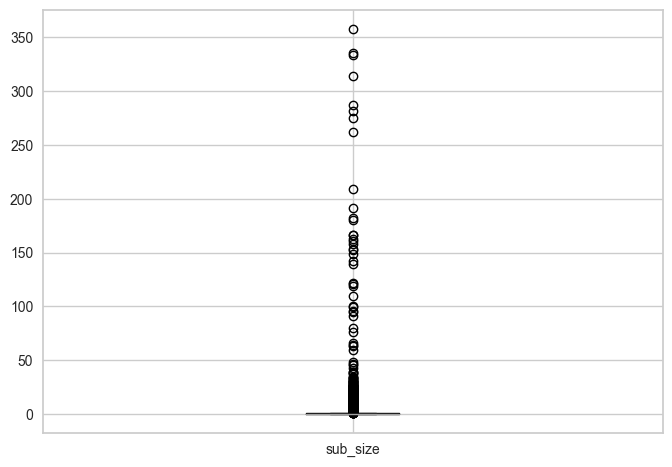

In [107]:
import matplotlib.pyplot as plt
import pandas as pd
train_resampled[['sub_size']].boxplot()
plt.show()

In [9]:
train_resampled = train_resampled[(train_resampled['past_login_total']<=400)&(train_resampled['past_1_month_login']<=80)&(train_resampled['past_login_total']<=15)]

#### 스케일링

### **AUTOML**

In [83]:
import pycaret 
from pycaret.classification import *

In [113]:
classification = setup(data=train_resampled, target='login', 
                       train_size=0.8, session_id=seed, ignore_features=['person_id'])

,Description,Value
0,Session id,42
1,Target,login
2,Target type,Binary
3,Original data shape,"(1999, 10)"
4,Transformed data shape,"(1999, 9)"
5,Transformed train set shape,"(1599, 9)"
6,Transformed test set shape,"(400, 9)"
7,Ignore features,1
8,Numeric features,8
9,Preprocess,True


In [114]:
best = compare_models(sort='AUC', include=['rf'])
#tuned_model = [tune_model(i) for i in best]
tuned_model = tune_model(best, optimize='AUC', fold=10)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,02:24:10
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8956,0.9441,0.8543,0.9163,0.8831,0.7890,0.7920,0.0530


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9125,0.9639,0.9467,0.8765,0.9103,0.8251,0.8275
1,0.8875,0.9687,0.8667,0.8904,0.8784,0.7738,0.7740
2,0.8625,0.9313,0.8784,0.8333,0.8553,0.7245,0.7254
3,0.8812,0.9336,0.7973,0.9365,0.8613,0.7587,0.7662
4,0.8000,0.9052,0.8243,0.7625,0.7922,0.6000,0.6017
5,0.8750,0.9299,0.8243,0.8971,0.8592,0.7472,0.7493
6,0.8438,0.9183,0.8784,0.8025,0.8387,0.6878,0.6904
7,0.9000,0.9569,0.8784,0.9028,0.8904,0.7985,0.7987
8,0.8312,0.9016,0.8514,0.7975,0.8235,0.6622,0.6635


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [86]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [115]:
best_params = tuned_model.get_params()
best_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

### **GridSearchCV**

그리드 서치(Grid Search)는 사용자가 정의한 하이퍼 파라미터들의 가능한 모든 조합을 시스템적으로 탐색하여, 모델의 성능을 최대화하는 하이퍼 파라미터 조합을 찾습니다.

이 과정은 크게 아래와 같은 단계로 이루어집니다.

1. 하이퍼 파라미터 그리드 설정

사용자는 탐색할 하이퍼 파라미터와 각 하이퍼 파라미터의 범위 또는 가능한 값들을 명시적으로 정의합니다.
이 과정에서 생성된 모든 가능한 하이퍼 파라미터 조합이 "그리드"를 형성합니다.

2. 모델 학습

각각의 하이퍼 파라미터에 대해 실험하고자 하는 값들의 리스트를 저으이하고, 이 리스트들의 가능한 모든 조합을 만들어 각 조합에 대해 모델을 학습시킨 후, 성능을 평가합니다.

3. 최적의 하이퍼 파라미터 선택

모든 조합의 성능을 평가한 후, 가장 좋은 성능을 보인 하이퍼 파라미터의 조합을 최적의 설정으로 선택합니다.

- 장점

가능한 모든 조합을 탐색하기 때문에 설정된 범위 내에서 최적의 하이퍼 파라미터 조합을 놓치지 않고 찾을 수 있습니다.
구현이 비교적 간단하며, 복잡한 최적화 알고리즘이 필요 없습니다.

- 단점

모든 조합을 시도하기 때문에 하이퍼 파라미터의 수나 범위가 클 경우 계산 비용이 매우 높아집니다.
모든 조합을 무조건적으로 탐색하기 때문에 중요하지 않은 파라미터에 대한 탐색에도 많은 시간을 소비할 수 있습니다.
본 베이스라인에서는 Random Forest의 하이퍼 파라미터 튜닝을 위해 GridSearchCV를 사용합니다.

**GridSearch**

교차 검증을 사용하지 않고, 모델 학습데이터에 대해서만 평가하기 때문에 과적합(overfitting) 가능성이 높습니다.

**GridSearchCV**

교차 검증을 사용하여 여러 개의 서로 다른 데이터 폴드에 대해 학습하고 평가하여 보다 안정적인 성능 평가 결과를 얻을 수 있습니다.

In [29]:
X_train = train_resampled.drop(['person_id', 'login'], axis=1)
y_train = train_resampled['login']

In [ ]:
# GridSearchCV를 위한 하이퍼파라미터 설정
param_search_space = {
    'n_estimators': [100, 120, 150, 200, 300], #10 ~ 1000 사이의 양의 정수
    'criterion' : ['gini', 'entropy'],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5, 10], # 2 이상의 정수 또는 0과 1 사이의 실수
    'min_samples_leaf': [1, 4, 5], # 1 이상의 정수 또는 0과 0.5 사이의 실수
    'min_weight_fraction_leaf': [0.1, 0.3, 0.4],  # 0.0에서 0.5 사이의 실수
    'max_features': ['auto', 'sqrt', 'log2', None], # 'auto', 'sqrt', 'log2', None 또는 양의 정수/실수
    #'max_leaf_nodes' : [],
    #'min_impurity_decrease' : [],
    'bootstrap' : [True, False]
}

In [19]:
# RandomForestClassifier 객체 생성
rf = RandomForestClassifier(random_state=seed)

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=rf, param_grid=param_search_space, cv=3, n_jobs=-1, verbose=2, scoring='roc_auc')

# GridSearchCV를 사용한 학습
grid_search.fit(X_train, y_train)

# 최적의 파라미터와 최고 점수 출력
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params

Fitting 3 folds for each of 6480 candidates, totalling 19440 fits


KeyboardInterrupt: 

### **RandomSearch**

In [ ]:
param_random_search = {
    'n_estimators': list(np.linspace(10, 1000, 500, dtype = int)), #10 ~ 1000 사이의 양의 정수
    'criterion' : ['gini', 'entropy'],
    'max_depth': list(np.linspace(10, 1500, 100, dtype = int)) + [None],
    'min_samples_split': list(np.linspace(2, 20, dtype = 'float64')), # 2 이상의 정수 또는 0과 1 사이의 실수
    'min_samples_leaf': list(np.linspace(1, 20, dtype = 'float64')), # 1 이상의 정수 또는 0과 0.5 사이의 실수
    'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],  # 0.0에서 0.5 사이의 실수
    'max_features': ['auto', 'sqrt', 'log2', None], # 'auto', 'sqrt', 'log2', None 또는 양의 정수/실수
    'max_leaf_nodes' : randint(low=0, high=100),
    'min_impurity_decrease' : randint(low=0, high=100),
    'bootstrap' : [True, False]
}

In [124]:
rf = RandomForestClassifier(random_state=seed)
random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_random_search, n_iter = 80, 
                               cv = 10, verbose= 3, random_state= seed, n_jobs = -1)
random_search.fit(X_train,y_train)

# 최적의 파라미터와 최고 점수 출력
best_params = random_search.best_params_
best_score = random_search.best_score_

best_params

Fitting 10 folds for each of 80 candidates, totalling 800 fits


{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 341,
 'max_features': 'sqrt',
 'max_leaf_nodes': 87,
 'min_impurity_decrease': 36,
 'min_samples_leaf': 14,
 'min_samples_split': 17,
 'min_weight_fraction_leaf': 0.3,
 'n_estimators': 77}

In [126]:
best_params

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 341,
 'max_features': 'sqrt',
 'max_leaf_nodes': 87,
 'min_impurity_decrease': 36,
 'min_samples_leaf': 14,
 'min_samples_split': 17,
 'min_weight_fraction_leaf': 0.3,
 'n_estimators': 77}

#### **Optuna**

In [58]:
import optuna
import sklearn

def objective(trial):
    param_random_search = {
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500), #10 ~ 1000 사이의 양의 정수
        'criterion' : trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_depth' : trial.suggest_int('max_depth', 1, 200),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100), # 2 이상의 정수 또는 0과 1 사이의 실수
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100), # 1 이상의 정수 또는 0과 0.5 사이의 실수
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0, 0.5),  # 0.0에서 0.5 사이의 실수
        'max_features': trial.suggest_int('max_features', 1, 100), # 'auto', 'sqrt', 'log2', None 또는 양의 정수/실수
        'max_leaf_nodes' : trial.suggest_int('max_leaf_nodes', 2, 100),
        'min_impurity_decrease' : trial.suggest_int('min_impurity_decrease', 0, 100),
        'bootstrap' : trial.suggest_categorical('bootstrap', [True, False])
        }
    rf = RandomForestClassifier(**param_random_search)
    rf.fit(X_train, y_train)
    
    score = cross_val_score(rf, X_train, y_train, cv=10, scoring="roc_auc_ovr")
    AUC_mean = score.mean()

    return AUC_mean


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
best_params = study.best_trial.params
best_params

[I 2024-03-29 21:38:23,782] A new study created in memory with name: no-name-45cfdbef-5228-44cf-ad1b-153ab5948c4b
[I 2024-03-29 21:38:27,442] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 352, 'criterion': 'gini', 'max_depth': 193, 'min_samples_split': 58, 'min_samples_leaf': 18, 'min_weight_fraction_leaf': 0.3221358273742885, 'max_features': 1, 'max_leaf_nodes': 91, 'min_impurity_decrease': 64, 'bootstrap': False}. Best is trial 0 with value: 0.5.
[I 2024-03-29 21:38:31,984] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 348, 'criterion': 'gini', 'max_depth': 133, 'min_samples_split': 30, 'min_samples_leaf': 80, 'min_weight_fraction_leaf': 0.13693071285601593, 'max_features': 20, 'max_leaf_nodes': 29, 'min_impurity_decrease': 40, 'bootstrap': False}. Best is trial 0 with value: 0.5.
[I 2024-03-29 21:38:35,364] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 258, 'criterion': 'gini', 'max_depth': 84, 'min_samples_split': 75, 'min

{'n_estimators': 239,
 'criterion': 'entropy',
 'max_depth': 137,
 'min_samples_split': 25,
 'min_samples_leaf': 16,
 'min_weight_fraction_leaf': 0.11266871831373056,
 'max_features': 21,
 'max_leaf_nodes': 21,
 'min_impurity_decrease': 0,
 'bootstrap': False}

In [59]:
best_params = study.best_trial.params
best_params

{'n_estimators': 239,
 'criterion': 'entropy',
 'max_depth': 137,
 'min_samples_split': 25,
 'min_samples_leaf': 16,
 'min_weight_fraction_leaf': 0.11266871831373056,
 'max_features': 21,
 'max_leaf_nodes': 21,
 'min_impurity_decrease': 0,
 'bootstrap': False}

### 최적 파라미터 저장

In [36]:
submit_first = pd.read_csv('./data/submit7.csv')
submit_second = pd.read_csv('./data/submit12.csv')
display(submit_first,submit_second)

,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,max_leaf_nodes,min_impurity_decrease,bootstrap
0,229,entropy,34,8,15,0.027581,auto,70,0,False


,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,max_leaf_nodes,min_impurity_decrease,bootstrap
0,237,gini,108,4,19,0.009877,0.4,47,0,False


In [63]:
submit17 = submit_first.copy()

In [60]:
submit = pd.read_csv('./data/sample_submission.csv')

# 찾은 최적의 파라미터들을 제출 양식에 맞게 제출
for param, value in best_params.items():
    if param in submit.columns:
        submit[param] = value
submit

,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,max_leaf_nodes,min_impurity_decrease,bootstrap
0,239,entropy,137,25,16,0.112669,21,21,0,False


In [64]:
submit17.to_csv('./data/submit17.csv', index=False)

: 